In [23]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier

import joblib

from libs.container import Container
import dataset

In [2]:
cpu = joblib.cpu_count()

In [3]:
data = dataset.load_scaled()

df = pd.concat([data.b278, data.b261])

cls = {name: idx for idx, name in enumerate(df.tile.unique())}
df["cls"] = df.tile.apply(cls.get)

print(cls)

del data

Reading '/mnt/is0/jbcabral/denoise/dataset/full_scaled.pkl.bz2'
{'b278': 0, 'b261': 1}


In [6]:
sel = joblib.load("results/rfecv.pkl.bz2")
sel

RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='entropy',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=500, n_jobs=10,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring=None, step=1, verbose=0)

In [7]:
rdf = pd.DataFrame({
    "Feature": dataset.FEATURES, 
    "Selected": sel.support_, "Ranking": sel.ranking_})
rdf = rdf.reset_index(drop=True)

In [8]:
selected = sum(rdf.Selected.values)
print("Selected Features: ", selected)

Selected Features:  24


In [9]:
def is_selected(row):
    if row.Selected:
        return pd.Series('background-color: #7EA489', row.index)
    return pd.Series('', row.index)


with pd.option_context('display.precision', 4):
    html = rdf.sort_values("Ranking").style.apply(is_selected, axis=1)
html

,Feature,Selected,Ranking
61,ppmb,True,1
33,MaxSlope,True,1
34,Mean,True,1
38,PercentAmplitude,True,1
24,Freq3_harmonics_amplitude_0,True,1
39,PercentDifferenceFluxPercentile,True,1
40,PeriodLS,True,1
42,Psi_CS,True,1
43,Psi_eta,True,1
44,Q31,True,1


In [10]:
X = df[dataset.FEATURES].values
y = df.cls.values
sel.score(X, y)

1.0

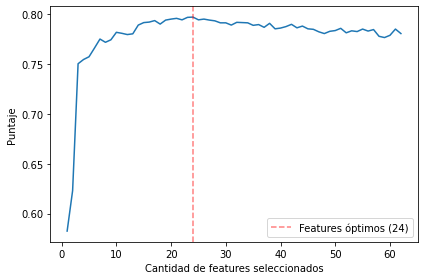

In [11]:
plt.figure()
plt.xlabel("Cantidad de features seleccionados")
plt.ylabel("Puntaje")
plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
plt.tight_layout()
plt.savefig("plots/rfe.pdf")
plt.show()

In [12]:
sX_columns = rdf[rdf.Selected].Feature.values
joblib.dump(sX_columns, "results/rfe_features.pkl.bz2", compress=3)
sX_columns

array(['Eta_e', 'Freq1_harmonics_amplitude_0',
       'Freq2_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_0',
       'LinearTrend', 'MaxSlope', 'Mean', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'PeriodLS', 'Psi_CS', 'Psi_eta',
       'Q31', 'Rcs', 'Skew', 'Std', 'c89_m2', 'c89_m4', 'n09_c3',
       'n09_hk_color', 'n09_jh_color', 'n09_m2', 'n09_m4', 'ppmb'],
      dtype=object)

In [13]:
nX_columns = rdf[~rdf.Selected].Feature.values
joblib.dump(nX_columns, "results/not_rfe_features.pkl.bz2", compress=3)
nX_columns

array(['Amplitude', 'Autocor_length', 'Beyond1Std', 'Con',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_1',
       'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3',
       'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
       'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_1',
       'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3',
       'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2',
       'Freq3_harmonics_rel_phase_3', 'Gskew', 'MedianAbsDev',
       'MedianBRP', 'PairSlopeTrend', 'Period_fit', 'SmallKurtosis',
       'c89_c3', 'c89_hk_color', 'c89_jh_color', 'c89_jk_color',


In [14]:
def execute_kfold(clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = Container({
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)})    
    return result

In [24]:
%%time

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
RF_PARAMS = BEST_PARAMS["rf"].best_params_

del BEST_PARAMS

fname = "results/rfe_clf.pkl.bz2"
if  os.path.exists(fname):
    rfe_clf  = Container(joblib.load(fname))
else:
    rfe_clf = execute_kfold(
        clf_name="RF", 
        clasificator=RandomForestClassifier(**RF_PARAMS), 
        sample=df, X_columns=sX_columns, y_column="cls", nfolds=10)
    joblib.dump(dict(rfe_clf), fname, compress=3)
    
rfe_clf["clf_name"] = "RFE"
rfe_clf["clf_name"]

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      2000
         1.0       0.80      0.78      0.79      2000

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000

--------------------------------------------------------------------------------
CPU times: user 4min 59s, sys: 3.62 s, total: 5min 3s
Wall time: 42.5 s


'RFE'

In [26]:
%%time

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")
RF_PARAMS = BEST_PARAMS["rf"].best_params_

del BEST_PARAMS

fname = "results/not_rfe_clf.pkl.bz2"
if os.path.exists(fname):
    not_rfe_clf  = Container(joblib.load(fname))
else:
    not_rfe_clf = execute_kfold(
        clf_name="RF", 
        clasificator=RandomForestClassifier(**RF_PARAMS), 
        sample=df, X_columns=nX_columns, y_column="cls", nfolds=10)
    joblib.dump(dict(not_rfe_clf), fname, compress=3)
not_rfe_clf["clf_name"] = "Not-RFE"
not_rfe_clf["clf_name"]

              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60      2000
         1.0       0.60      0.62      0.61      2000

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000

--------------------------------------------------------------------------------
CPU times: user 8min 3s, sys: 3.09 s, total: 8min 6s
Wall time: 59.2 s


'Not-RFE'

In [31]:
clf = Container(joblib.load("results/model_selection.pkl.bz2")[2])
print(clf.clf_name)
clf["clf_name"] = "All features"
clf["clf_name"]

RF


'All features'

In [32]:
results = [rfe_clf, not_rfe_clf, clf]

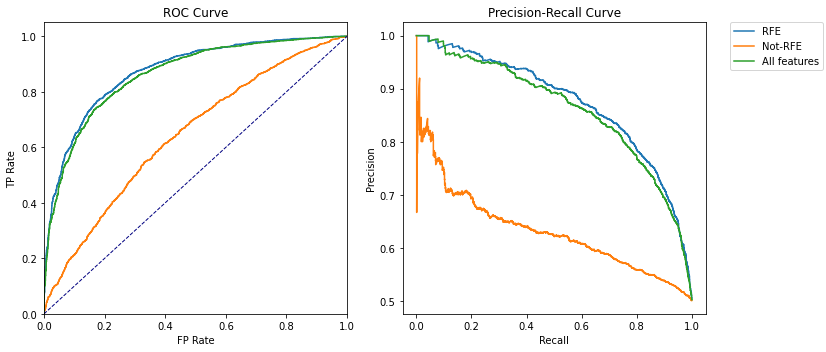

In [33]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
roc(results, ax=ax[0])
prc(results, ax=ax[1], labels=False)

lgd = fig.legend(bbox_to_anchor=(1.15, 0.93))
fig.tight_layout();

fig.savefig("plots/rfe_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [34]:
rows = []
for r in results:
    prec = metrics.precision_score(r.real_cls, r.predictions)
    rec = metrics.recall_score(r.real_cls, r.predictions)
    rows.append({"Model": r.clf_name, "Precision": prec, "Recall": rec, "AUC": r.roc_auc})
resume = pd.DataFrame(rows)
resume

,Model,Precision,Recall,AUC
0,RFE,0.798980,0.7830,0.873290
1,Not-RFE,0.602125,0.6235,0.642803
2,All features,0.789636,0.7695,0.862328


In [35]:
print(resume.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
        Model &  Precision &  Recall &   AUC \\
\midrule
          RFE &      0.799 &   0.783 & 0.873 \\
      Not-RFE &      0.602 &   0.624 & 0.643 \\
 All features &      0.790 &   0.769 & 0.862 \\
\bottomrule
\end{tabular}

